In [292]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Tuple
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [293]:
data_dict = {}
current_key = None
current_values = []

with open('ItalyPowerDemand_TRAIN.ts', 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith('@'):
            if current_key is not None:
                if len(current_values) == 1:
                    data_dict[current_key] = current_values[0]
                else:
                    data_dict[current_key] = current_values
                current_values = []
            current_key = line
        else:
            current_values.append(line)

if current_key is not None:
    if len(current_values) == 1:
        data_dict[current_key] = current_values[0]
    else:
        data_dict[current_key] = current_values

In [294]:
split_data = [item.split(':') for item in data_dict['@data']]
pdfeatures0 = [list(map(float, item[0].split(','))) for item in split_data]
features0 = np.array([list(map(float, item[0].split(','))) for item in split_data])
labels = [1 if int(item[-1])==1 else 0 for item in split_data]
pddf = pd.DataFrame({'F1': pdfeatures0, 'Labels': labels})
df = np.array(features0)
labels = np.array(labels, dtype=int)

In [295]:
df_features = torch.tensor(df).float().unsqueeze(1)
df_labels = torch.tensor(labels).long()
df_features_t = torch.transpose(df_features, 1, 2)

In [296]:
df_train_features, df_train_labels, df_test_features, df_test_labels = df_features_t[:34,:, :], df_labels[:34], df_features_t[34:,:, :], df_labels[34:]

In [297]:
from torch.nn.modules.batchnorm import BatchNorm1d
def attention(
        query: torch.tensor,
        key: torch.tensor,
        value: torch.tensor
) -> Tuple[torch.tensor, torch.tensor]:
    d = query.shape[-1]
    coefficient_matrix = torch.matmul(query, key.transpose(1,2))/torch.sqrt(torch.tensor(d).float())# TODO
    softmax = nn.Softmax(dim=-1)
    attention_matrix = softmax(coefficient_matrix)# TODO
    out = torch.matmul(attention_matrix, value)# TODO
    return attention_matrix, out

class Attention(nn.Module):
    def __init__(
        self,
        dim_in: int,
        dim_q: int,
        dim_k: int,
    ):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_q)
        self.k = nn.Linear(dim_in, dim_k)
        self.v = nn.Linear(dim_in, dim_k)

    def forward(
        self,
        query: torch.tensor,
        key: torch.tensor,
        value: torch.tensor
) -> Tuple[torch.tensor, torch.tensor]:
        query = self.q(query)
        key = self.k(key)
        value = self.v(value)

        self.A, out = attention(query, key, value)# TODO

        return out
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(LSTM, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(hidden_size),
        nn.Dropout(0.7),
        nn.Linear(hidden_size, 1000),
        nn.ReLU(),
        nn.BatchNorm1d(1000),
        nn.Dropout(0.5),
        nn.Linear(1000, num_classes)
    )
    self.activation = nn.Softmax(dim=1)

  def forward(self, x):
    h0 = torch.ones(self.num_layers, x.size(0), self.hidden_size)
    c0 = torch.ones(self.num_layers, x.size(0), self.hidden_size)
    out, _ = self.lstm(x, (h0, c0))
    out = out[:, -1, :]
    out = self.linear(out)
    return self.activation(out)

class LSTMAtt(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(LSTMAtt, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.attention = Attention(hidden_size, hidden_size, hidden_size)
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(hidden_size),
        nn.Dropout(0.7),
        nn.Linear(hidden_size, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.Linear(1024, num_classes)
    )
    self.activation = nn.Softmax(dim=1)

  def forward(self, x):
    h0 = torch.ones(self.num_layers, x.size(0), self.hidden_size)
    c0 = torch.ones(self.num_layers, x.size(0), self.hidden_size)
    out, _ = self.lstm(x, (h0, c0))
    out = self.attention(out, out, out)
    out = out[:, -1, :]
    out = self.classifier(out)
    return self.activation(out)

class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(64, 64, kernel_size=5),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.7),
            nn.Linear(128, num_classes)
        )
        self.act = nn.Softmax(dim=1)
    def forward(self, x):
        return self.act(self.classifier(self.features(x)))


In [298]:
from IPython.display import clear_output
model = LSTM(1, 10, 1, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(100):
    clear_output(wait=True)
    model.train()
    optimizer.zero_grad()
    outputs = model(df_train_features)
    loss = criterion(outputs.float(), df_train_labels.squeeze())
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        outputs = model(df_test_features)
        _, predictions = torch.max(outputs.data, 1)
    # print(predictions)
    print(f'Epoch = {epoch}, Loss = {loss}, Training_acc = {balanced_accuracy_score(df_train_labels, torch.argmax(model(df_train_features), dim=1))}, Acc = {balanced_accuracy_score(df_test_labels, predictions)}')

Epoch = 99, Loss = 0.4334043264389038, Training_acc = 0.9377289377289377, Acc = 0.925


In [299]:
model = LSTMAtt(1, 30, 1, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(140):
    clear_output(wait=True)
    model.train()
    optimizer.zero_grad()
    outputs = model(df_train_features)
    loss = criterion(outputs.float(), df_train_labels.squeeze())
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        outputs = model(df_test_features)
        _, predictions = torch.max(outputs.data, 1)
    # print(predictions)
    print(f'Epoch = {epoch}, Loss = {loss}, Training_acc = {balanced_accuracy_score(df_train_labels, torch.argmax(model(df_train_features), dim=1))}, Acc = {balanced_accuracy_score(df_test_labels, predictions)}')

Epoch = 139, Loss = 0.441200852394104, Training_acc = 0.8461538461538461, Acc = 0.95


In [300]:
df_train_features = df_train_features.transpose(1,2)
df_test_features = df_test_features.transpose(1,2)

In [301]:
model = CNN(2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(50):
    clear_output(wait=True)
    outputs = model(df_train_features)
    loss = criterion(outputs, df_train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        outputs = model(df_test_features)
        predictions = torch.argmax(outputs, dim=1)
    # print(predictions)
    print(f'Epoch = {epoch}, Loss = {loss}, Training_acc = {balanced_accuracy_score(df_train_labels, torch.argmax(model(df_train_features), dim=1))}, Acc = {balanced_accuracy_score(df_test_labels, predictions)}')

Epoch = 49, Loss = 0.34067970514297485, Training_acc = 0.9377289377289377, Acc = 1.0


In [302]:
data_dict = {}
current_key = None
current_values = []

with open('ItalyPowerDemand_TEST.ts', 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith('@'):
            if current_key is not None:
                if len(current_values) == 1:
                    data_dict[current_key] = current_values[0]
                else:
                    data_dict[current_key] = current_values
                current_values = []
            current_key = line
        else:
            current_values.append(line)

if current_key is not None:
    if len(current_values) == 1:
        data_dict[current_key] = current_values[0]
    else:
        data_dict[current_key] = current_values

split_data = [item.split(':') for item in data_dict['@data']]
pdfeatures0 = [list(map(float, item[0].split(','))) for item in split_data]
features0 = np.array([list(map(float, item[0].split(','))) for item in split_data])
labels = [1 if int(item[-1])==1 else 0 for item in split_data]
pddf = pd.DataFrame({'F1': pdfeatures0, 'Labels': labels})
df = np.array(features0)
labels = np.array(labels, dtype=int)

df_features = torch.tensor(df).float().unsqueeze(1)
df_labels = torch.tensor(labels).long()

In [303]:
with torch.no_grad():
    outputs = model(df_features)
    predictions = torch.argmax(outputs, dim=1)
    print(f'Acc = {balanced_accuracy_score(df_labels, predictions)}')

Acc = 0.9136690239811415


In [304]:
pre_trained_model = CNN(2)
pre_trained_model.load_state_dict(model.state_dict())
for p in pre_trained_model.parameters():
  p.requires_grad_(False)

df_features.requires_grad = True
output = pre_trained_model(df_features)
output.max().backward()

saliency_map = df_features.grad.abs()
df_features.requires_grad = False

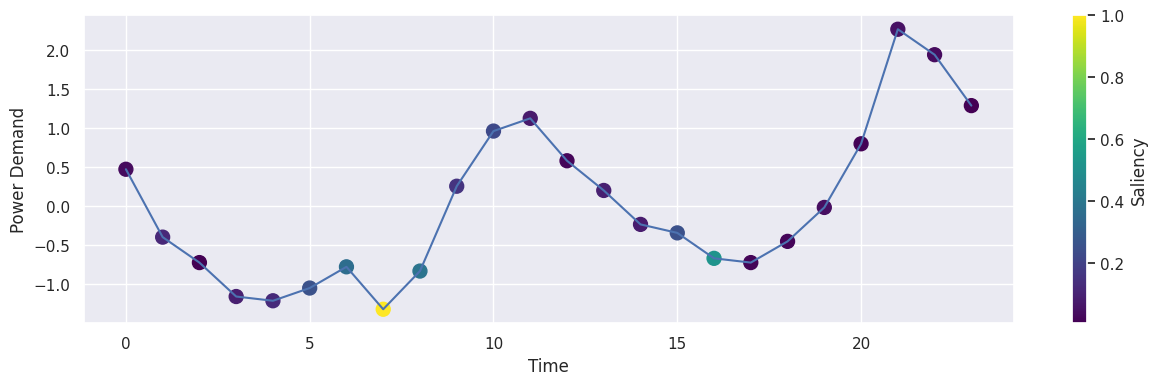

In [305]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
x = df_features[0,:,:].squeeze().detach().numpy()
y = saliency_map[0,:,:].squeeze().detach().numpy()/saliency_map[0,:,:].squeeze().detach().numpy().max()
plt.plot()
plt.plot(range(24), x)
plt.scatter(range(24), x, c=y, cmap='viridis', marker='o', s=100)
cbar = plt.colorbar()
cbar.set_label('Saliency')

plt.xlabel('Time')
plt.ylabel('Power Demand')

plt.show()

In [306]:
from torch.nn.modules.loss import CrossEntropyLoss
new_df = df_features
new_labels = df_labels
new_df.requires_grad=True
epsilon = 0.1
criterion = CrossEntropyLoss()
pre_trained_model = CNN(2)
pre_trained_model.load_state_dict(model.state_dict())
pre_trained_model.eval()
output = pre_trained_model(new_df)
loss = criterion(output, new_labels)
pre_trained_model.zero_grad()
loss.backward()
data_grad = new_df.grad.data
new_df.requires_grad = False
perturbed_data = new_df + epsilon * data_grad.sign()

In [307]:
with torch.no_grad():
    outputs = model(perturbed_data)
    predictions = torch.argmax(outputs, dim=1)
    print(f'Acc = {balanced_accuracy_score(df_labels, predictions)}')

Acc = 0.728993834715989


In [308]:
pre_trained_model = CNN(2)
pre_trained_model.load_state_dict(model.state_dict())
for p in pre_trained_model.parameters():
  p.requires_grad_(False)

perturbed_data.requires_grad = True
output = pre_trained_model(perturbed_data)
output.max().backward()

saliency_map = perturbed_data.grad.abs()
perturbed_data.requires_grad = False

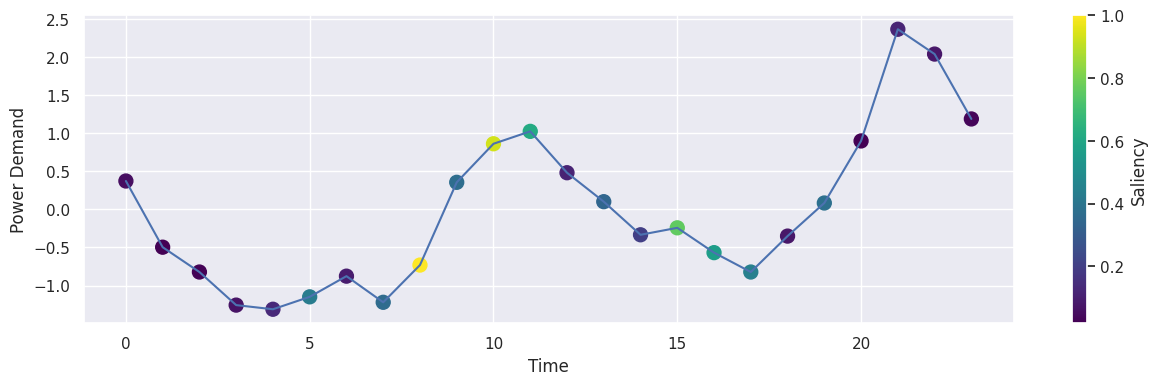

In [309]:
plt.figure(figsize=(15,4))
x = perturbed_data[0,:,:].squeeze().detach().numpy()
y = saliency_map[0,:,:].squeeze().detach().numpy()/saliency_map[0,:,:].squeeze().detach().numpy().max()
plt.plot()
plt.plot(range(24), x)
plt.scatter(range(24), x, c=y, cmap='viridis', marker='o', s=100)
cbar = plt.colorbar()
cbar.set_label('Saliency')

plt.xlabel('Time')
plt.ylabel('Power Demand')

plt.show()